In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from src.trainer import Trainer
from src.vit import VitDetector
import matplotlib.pyplot as plt
from src.loader import AirPlaneData, I_SIZE

import albumentations as A
from albumentations.pytorch import ToTensorV2

import sklearn.metrics as metrics
from src.losses import IoULoss,  bbox_diou, bbox_iou, bbox_giou

In [2]:
LR = 1e-4
BETA = 1
ALPHA = 1
EPOCHS = 200
BATCH_SIZE = 32
WEIGHT_DECAY = 1e-2 # 1e-4
EARLY_STOP_STEPS = 30
MODEL_SAVE_PATH = "models/model_vit.pth"

In [3]:
train_transform = A.Compose([
    A.Resize(I_SIZE, I_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(
        scale=(0.95, 1.05),
        translate_percent=(0.05, 0.05),
        rotate=(-10, 10),
        shear=0,
        border_mode=0,
        p=0.5
    ),
    A.ColorJitter(p=0.5),
    A.MotionBlur(p=0.2),
    A.Normalize(mean=(0,0,0), std=(1.0,1.0,1.0)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(I_SIZE, I_SIZE),
    A.Normalize(mean=(0,0,0), std=(1.0,1.0,1.0)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [4]:
air_plane_data = AirPlaneData(train_txt="database/train.txt", test_txt="database/test.txt")
train_loader, test_loader = air_plane_data(batch_size=BATCH_SIZE, train_transf=train_transform, test_transf=test_transform)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else DEVICE)

In [5]:
# --------------PATCHES---------------
img_size = I_SIZE
patch_size = 16
n_patches = (img_size * img_size) // (patch_size * patch_size)

# --------------TRANSFORMER---------------
input_shape = patch_size * patch_size * 3
d_model = 192
num_heads = 3
n_layers = 12
ln_epsilon = 1e-5
d_ff = d_model * 4
ff_dropout_rate = 0.25

# --------------PREDICTION---------------
num_classes = 3
cls_head_activation = "gelu"
cls_head_layers_units = [2048, 1024, 512, 256] # [2048, 1024, 512, 64, 32]
cls_head_layers_dropout = [0.25, 0.25, 0.25, 0.25] # [0.25, 0.25, 0.25, 0.25, 0.25]

params = {
    "patch_size": patch_size,
    "n_patches": n_patches,

    "input_shape": input_shape,
    "d_model": d_model,
    "num_heads": num_heads,
    "n_layers": n_layers,
    "ln_epsilon": ln_epsilon,
    "d_ff": d_ff,
    "ff_dropout_rate": ff_dropout_rate,

    "n_classes": num_classes,
    "cls_head_activation": cls_head_activation,
    "cls_head_layers_units": cls_head_layers_units,
    "cls_head_layers_dropout": cls_head_layers_dropout
}

In [6]:
model = VitDetector(params=params)
print("Number of parameters: ", sum([params.numel()for params in model.parameters()]))

Number of parameters:  5525383


In [7]:
criterion_box = IoULoss()
criterion_cls = nn.CrossEntropyLoss(weight=None)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
trainer = Trainer(model=model, device=DEVICE, optimizer=optimizer, criterion_box=criterion_box, criterion_cls=criterion_cls, alpha=ALPHA, beta=BETA)

In [8]:
test_losses = []
train_losses = []

test_accuracies = []
train_accuracies = []

test_box_losses = []
train_box_losses = []

test_cls_losses = []
train_cls_losses = []
best_loss = float('inf')
n_early = 0

In [9]:
pbar = tqdm(range(EPOCHS), desc="Epochs")
for epoch in pbar:
    trainer.init_train_parameters()
    for batch_train in train_loader:
        trainer.train_step(batch_train)
    
    for batch_test in test_loader:
        with torch.no_grad():
            trainer.eval_step(batch_test)
    train_loss = trainer.train_loss / len(train_loader)
    test_loss = trainer.eval_loss / len(test_loader)
    
    train_box_loss = trainer.train_loss_box / len(train_loader)
    test_box_loss = trainer.eval_loss_box / len(test_loader)
    
    train_cls_loss = trainer.train_loss_cls / len(train_loader)
    test_cls_loss = trainer.eval_loss_cls / len(test_loader)
    
    train_accuracy = trainer.train_accuracy / trainer.train_n_sample
    test_accuracy = trainer.eval_accuracy / trainer.eval_n_sample
    
    pbar.set_postfix({
        "train_loss": train_loss,
        "train_box_loss": train_box_loss,
        "train_cls_loss": train_cls_loss,
        "train_accuracy": train_accuracy,
        
        "test_loss": test_loss,
        "test_box_loss": test_box_loss,
        "test_cls_loss": test_cls_loss,
        "test_accuracy": test_accuracy,
        
        "best_box_loss": best_loss,
    })
    
    train_losses.append(train_loss)
    train_cls_losses.append(train_cls_loss)
    train_accuracies.append(train_accuracy)
    train_box_losses.append(train_box_loss)
    
    test_losses.append(test_loss)
    test_box_losses.append(test_box_loss)
    test_cls_losses.append(test_cls_loss)
    test_accuracies.append(test_accuracy)
    
    if test_box_loss < best_loss:
        n_early = 0
        best_loss = test_box_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH) 
    else:
        n_early += 1
    
    if n_early == EARLY_STOP_STEPS:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        print(f"Early stopping at epoch {epoch}")
        break

Epochs:  56%|█████▋    | 113/200 [50:10<38:38, 26.64s/it, train_loss=0.228, train_box_loss=0.141, train_cls_loss=0.087, train_accuracy=0.967, test_loss=0.288, test_box_loss=0.132, test_cls_loss=0.156, test_accuracy=0.95, best_box_loss=0.126]  

Early stopping at epoch 113


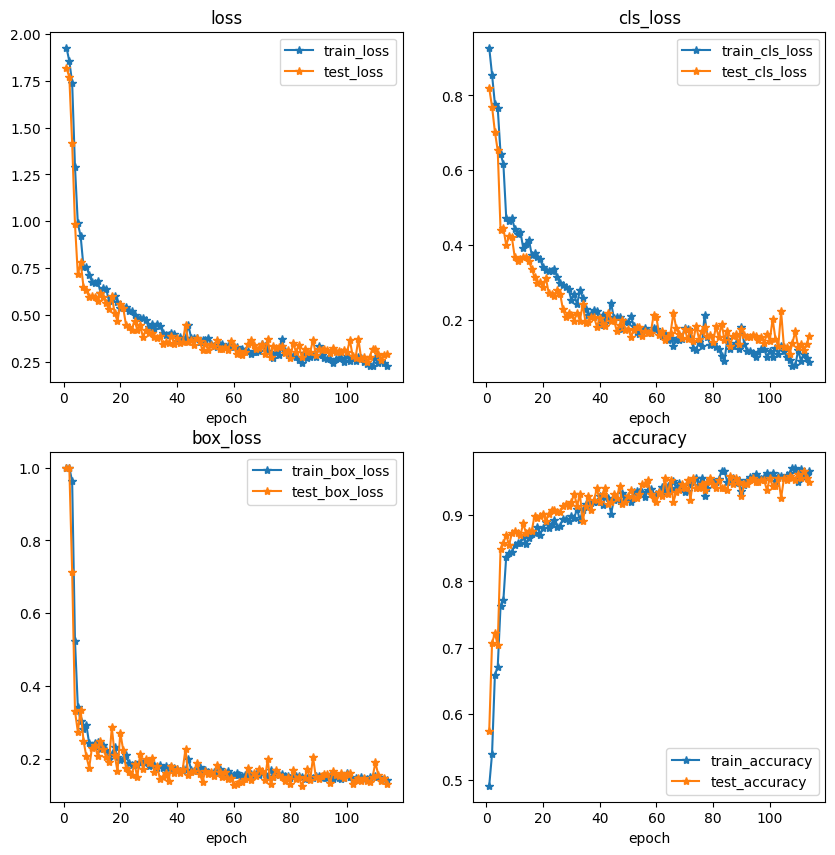

In [10]:
epoch_step = [i for i in range(1, len(train_losses)+1)]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(epoch_step, train_losses, '-*', label="train_loss")
ax[0, 0].plot(epoch_step, test_losses, '-*', label="test_loss")
ax[0, 0].set_title("loss")
ax[0, 0].set_xlabel("epoch")
ax[0, 0].legend()

ax[0, 1].plot(epoch_step, train_cls_losses, '-*', label="train_cls_loss")
ax[0, 1].plot(epoch_step, test_cls_losses, '-*', label="test_cls_loss")
ax[0, 1].set_title("cls_loss")
ax[0, 1].set_xlabel("epoch")
ax[0, 1].legend()

ax[1, 0].plot(epoch_step, train_box_losses, '-*', label="train_box_loss")
ax[1, 0].plot(epoch_step, test_box_losses, '-*', label="test_box_loss")
ax[1, 0].set_title("box_loss")
ax[1, 0].set_xlabel("epoch")
ax[1, 0].legend()

ax[1, 1].plot(epoch_step, train_accuracies, '-*', label="train_accuracy")
ax[1, 1].plot(epoch_step, test_accuracies, '-*', label="test_accuracy")
ax[1, 1].set_title("accuracy")
ax[1, 1].set_xlabel("epoch")
ax[1, 1].legend()
plt.show()

In [11]:
predicted_cls = []
ground_truth_cls = []

In [12]:
ious = []
dious = []
gious = []

In [13]:
with torch.no_grad():
    model.eval()
    model.to("cpu")
    for data in tqdm(test_loader):
        x, cls, box = data
        pred_cls, pred_box = model(x)
        for i in range(pred_cls.shape[0]):
            ious.append(bbox_iou(pred_box[i:i+1].detach().cpu(), box[i:i+1].cpu()))
            dious.append(bbox_diou(pred_box[i:i+1].detach().cpu(), box[i:i+1].cpu()))
            gious.append(bbox_giou(pred_box[i:i+1].detach().cpu(), box[i:i+1].cpu()))
            predicted_cls.append(pred_cls[i].argmax(-1).detach().cpu())
            ground_truth_cls.append(cls[i].cpu())

100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


In [14]:
print(metrics.classification_report(ground_truth_cls, predicted_cls))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       168
           1       0.65      0.76      0.70        17
           2       0.95      0.97      0.96       153

    accuracy                           0.94       338
   macro avg       0.86      0.89      0.87       338
weighted avg       0.94      0.94      0.94       338



In [15]:
print(metrics.confusion_matrix(ground_truth_cls, predicted_cls))

[[156   6   6]
 [  2  13   2]
 [  3   1 149]]


In [16]:
mean_iou = sum(ious) / len(ious)
print("Mean IoU:", mean_iou)

Mean IoU: tensor([0.8726])


In [17]:
mean_diou = sum(dious) / len(dious)
print("Mean DIoU:", mean_diou)

Mean DIoU: tensor([0.8717])


In [18]:
mean_giou = sum(gious) / len(gious)
print("Mean GIoU:", mean_giou)

Mean GIoU: tensor([1.6045])
